# Post-processing raw wrfout netcdf files

Notebook outlining how to read, process, and write wrfout netCDF files to Zarr (using wrf-python)

In [1]:
import os
from glob import glob
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt

import wrf
# from wrf import to_np, getvar, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords, ALL_TIMES, disable_xarray

xr.set_options(display_style="html");

In [2]:
from dask.distributed import Client, progress, LocalCluster
import numcodecs

cluster = LocalCluster()
cluster

In [3]:
client = Client(cluster)

In [4]:
numcodecs.blosc.use_threads = False

## Read in RAW wrfout tiles

In [5]:
gcsdir = '/Users/dporter/data/Antarctic/'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'wrfout_d03_20161222_week'
filepattern = 'wrfout_*'

pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

/Users/dporter/data/Antarctic/AMPS/WRF_24/wrfout_d03_20161222_week/wrfout_*


In [6]:
NCs = glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

Total of 56 wrf files.

/Users/dporter/data/Antarctic/AMPS/WRF_24/wrfout_d03_20161222_week/wrfout_d03_2016122512_f006.nc


In [7]:
NCs_urls = NCs

In [8]:
ncfile = Dataset(NCs_urls[0])
ncfile.variables.keys()

dict_keys(['Times', 'XLAT', 'XLONG', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN', 'CFN', 'CFN1', 'THIS_IS_AN_IDEAL_RUN', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'RDX', 'RDY', 'RESM', 'ZETATOP', 'CF1', 'CF2', 'CF3', 'ITIMESTEP', 'XTIME', 'QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'TSLB', 'SMOIS', 'SH2O', 'SMCREL', 'SEAICE', 'XICEM', 'SFROFF', 'UDROFF', 'IVGTYP', 'ISLTYP', 'VEGFRA', 'GRDFLX', 'ACGRDFLX', 'SNOW', 'SNOWH', 'CANWAT', 'SSTSK', 'LAI', 'MAPFAC_M', 'MAPFAC_U', 'MAPFAC_V', 'MAPFAC_MX', 'MAPFAC_MY', 'MAPFAC_UX', 'MAPFAC_UY', 'MAPFAC_VX', 'MF_VX_INV', 'MAPFAC_VY', 'F', 'E', 'SINALPHA', 'COSALPHA', 'HGT', 'TSK', 'P_TOP', 'T00', 'P00', 'TLP', 'TISO', 'TLP_STRAT', 'P_STRAT', 'MAX_MSTFX', 'MAX_MSTFY', 'RAINC', 'RAINNC', 'SNOWNC', 'GRAUPELNC', 'HAILNC', 'SWDOWN', 'GLW', 'ACLWUPT', 'ACLWUPTC', 'ACLWDNT', 'ACLWDNTC', 'ACLWUPB', 'ACLWUPBC', 'ACLWDNB', 'ACLWDNBC', 'I_ACLWUP

### get variables needed using wrf-python's `getvar`

In [9]:
# T_sfc = getvar(ncfile, "T_sfc")
# Td = getvar(ncfile, "tk")
da = wrf.getvar(ncfile, "T2", timeidx=wrf.ALL_TIMES)


In [10]:
# wrf.disable_xarray()
# T2 = getvar(ncfile, "T2")
# print (type(T2))
# wrf.enable_xarray()
# ##
# T2 = wrf.getvar(ncfile, "T2", meta=False)
# print (type(T2))
# T2

In [11]:
da

<xarray.DataArray 'T2' (south_north: 825, west_east: 537)>
array([[244.60104, 244.5688 , 244.62262, ..., 266.27325, 266.19458,
        266.1899 ],
       [244.48149, 244.50226, 244.53545, ..., 266.0931 , 266.02603,
        266.02823],
       [244.44785, 244.46301, 244.54413, ..., 265.89868, 265.84613,
        265.8914 ],
       ...,
       [265.16492, 265.17038, 265.2179 , ..., 270.9541 , 271.02048,
        271.09225],
       [265.34238, 265.37024, 265.42023, ..., 271.03113, 271.1353 ,
        271.2499 ],
       [265.57272, 265.62625, 265.68082, ..., 271.1483 , 271.2828 ,
        271.4339 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 59.9 59.8 59.71 ... -158.1 -158.0
    XLAT     (south_north, west_east) float32 -80.58 -80.61 ... -68.0 -67.99
    XTIME    float32 360.0
    Time     datetime64[ns] 2016-12-25T18:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   PolarStereographic(stand_lon=180.0, moad_cen_lat=-87.400062...

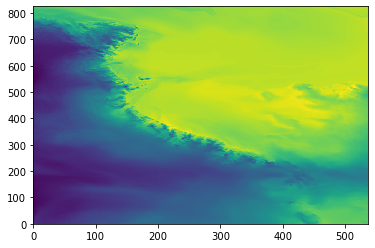

In [12]:
plt.pcolor(wrf.to_np(da))

In [13]:
# # Creating a simple test list with four timesteps
# wrflist = [Dataset(NCs_urls[0]),
#            Dataset(NCs_urls[1]),
#            Dataset(NCs_urls[2]),
#            Dataset(NCs_urls[3])]

wrflist = [Dataset(x) for x in NCs_urls]

In [14]:
da = wrf.getvar(wrflist, 
                "T2", 
                timeidx=wrf.ALL_TIMES, 
                method='cat') #, method="join", squeeze=False)
da

<xarray.DataArray 'T2' (Time: 56, south_north: 825, west_east: 537)>
array([[[244.60104, 244.5688 , 244.62262, ..., 266.27325, 266.19458,
         266.1899 ],
        [244.48149, 244.50226, 244.53545, ..., 266.0931 , 266.02603,
         266.02823],
        [244.44785, 244.46301, 244.54413, ..., 265.89868, 265.84613,
         265.8914 ],
        ...,
        [265.16492, 265.17038, 265.2179 , ..., 270.9541 , 271.02048,
         271.09225],
        [265.34238, 265.37024, 265.42023, ..., 271.03113, 271.1353 ,
         271.2499 ],
        [265.57272, 265.62625, 265.68082, ..., 271.1483 , 271.2828 ,
         271.4339 ]],

       [[246.43503, 246.46265, 246.50499, ..., 262.5171 , 262.47592,
         262.5644 ],
        [246.43079, 246.4603 , 246.5418 , ..., 262.38293, 262.3972 ,
         262.52948],
        [246.41502, 246.46059, 246.56554, ..., 262.28622, 262.35333,
         262.52853],
...
        [267.06033, 267.0826 , 267.10947, ..., 273.40292, 273.40424,
         273.38858],
        [267.16873, 267.2148 , 267.2506 , ..., 273.38794, 273.38843,
         273.44788],
        [267.2526 , 267.30057, 267.37482, ..., 273.43277, 273.44797,
         273.47086]],

       [[244.46605, 244.42435, 244.39299, ..., 264.11154, 264.12595,
         264.22852],
        [244.44365, 244.35782, 244.36887, ..., 264.136  , 264.14944,
         264.27194],
        [244.43575, 244.37717, 244.34227, ..., 264.1565 , 264.17834,
         264.30048],
        ...,
        [270.24973, 270.58035, 270.8354 , ..., 270.67294, 270.64795,
         270.62442],
        [270.035  , 270.3534 , 270.69418, ..., 270.6751 , 270.65198,
         270.6272 ],
        [269.8382 , 270.07376, 270.4904 , ..., 270.67502, 270.65497,
         270.6321 ]]], dtype=float32)
Coordinates:
    XLONG     (south_north, west_east) float32 59.9 59.8 59.71 ... -158.1 -158.0
    XLAT      (south_north, west_east) float32 -80.58 -80.61 ... -68.0 -67.99
    XTIME     (Time) float64 360.0 540.0 180.0 180.0 ... 360.0 540.0 180.0 720.0
  * Time      (Time) datetime64[ns] 2016-12-25T18:00:00 ... 2016-12-27T12:00:00
    datetime  (Time) datetime64[ns] 2016-12-25T18:00:00 ... 2016-12-27T12:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   PolarStereographic(stand_lon=180.0, moad_cen_lat=-87.400062...

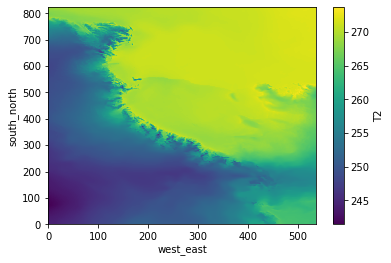

In [15]:
da.mean(dim='Time').plot()

In [16]:
da = da.chunk(chunks={'Time':-1})
da

<xarray.DataArray 'T2' (Time: 56, south_north: 825, west_east: 537)>
dask.array<xarray-<this-array>, shape=(56, 825, 537), dtype=float32, chunksize=(56, 825, 537), chunktype=numpy.ndarray>
Coordinates:
    XLONG     (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    XLAT      (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    XTIME     (Time) float64 dask.array<chunksize=(56,), meta=np.ndarray>
  * Time      (Time) datetime64[ns] 2016-12-25T18:00:00 ... 2016-12-27T12:00:00
    datetime  (Time) datetime64[ns] dask.array<chunksize=(56,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   PolarStereographic(stand_lon=180.0, moad_cen_lat=-87.400062...

In [17]:
%%time
da.mean().compute()

CPU times: user 158 ms, sys: 143 ms, total: 301 ms
Wall time: 590 ms


<xarray.DataArray 'T2' ()>
array(261.02563, dtype=float32)

In [18]:
ds = da.to_dataset()
ds

<xarray.Dataset>
Dimensions:   (Time: 56, south_north: 825, west_east: 537)
Coordinates:
    XLONG     (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    XLAT      (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    XTIME     (Time) float64 dask.array<chunksize=(56,), meta=np.ndarray>
  * Time      (Time) datetime64[ns] 2016-12-25T18:00:00 ... 2016-12-27T12:00:00
    datetime  (Time) datetime64[ns] dask.array<chunksize=(56,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    T2        (Time, south_north, west_east) float32 dask.array<chunksize=(56, 825, 537), meta=np.ndarray>

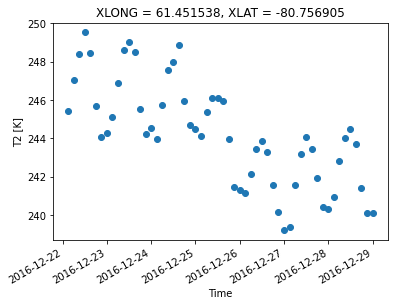

In [19]:
ds['T2'].isel(west_east=1, south_north=10).plot(marker="o",linestyle='')

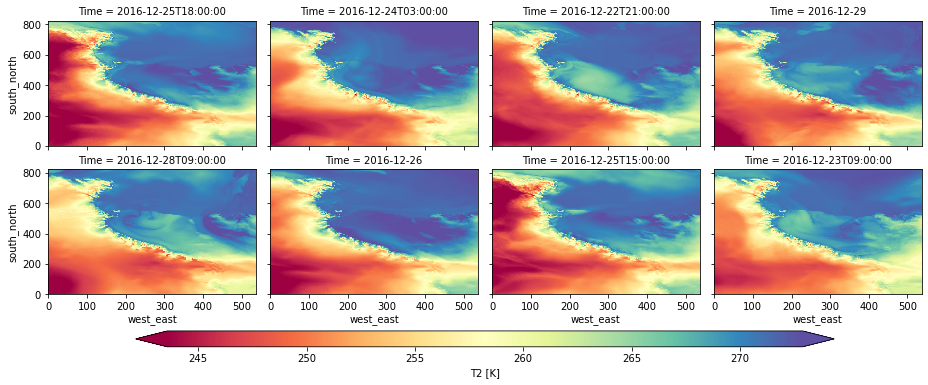

In [20]:
import matplotlib as mpl

# fg = ds.T2.isel(Time=range(0,16)).plot(col="Time",
#                                      col_wrap=4,
#                                      )

fg = ds.T2.isel(Time=range(0,16,2)).plot(
    col="Time",
    col_wrap=4,
    # normal kwargs
#     vmin=250, vmax=275,
    robust=True,
    cmap=mpl.cm.Spectral,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)

In [21]:
# import cartopy.crs as ccrs
# import shapely.geometry as sgeom

# box = sgeom.box(minx=160, maxx=200, miny=-88, maxy=-73)
# x0, y0, x1, y1 = box.bounds
# myproj = ccrs.SouthPolarStereo(central_longitude=180)


# fg = ds.T2.isel(Time=range(0,8,2))[:-1, :-1].plot(
#     x= 'XLONG', y='XLAT',
#     col="Time",
#     vmin=250, vmax=275,\
#     robust=True,
#     cmap=mpl.cm.Spectral,
#     transform=ccrs.PlateCarree(),  # remember to provide this!
#     subplot_kws={
#         "projection": ccrs.SouthPolarStereo(central_longitude=180)
#     },
#     cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
# )
# # for ax in fg.axes.flat:
# #     ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())
    
# # lets add a coastline to each axis
# # great reason to use FacetGrid.map
# fg.map(lambda: plt.gca().coastlines())

# Write to Zarr


In [ ]:
import gcsfs
from tqdm import tqdm
import fsspec

In [ ]:
gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'domain_03'

outdir = os.path.join(gcsdir, ampsdir, amps_ver, domain, 'zarr-postproc/')

In [ ]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

# fs.glob(outdir)
fs.ls(outdir)

In [ ]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'test_20161225-T2_projection.zarr', mode='ab',
                            token=token)


## Projections

### remove them altogether

but ideally give the PROJ4 string if appropriate

In [22]:
# del ds.T2.attrs['projection']

ds.T2.attrs['projection'] = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'

In [ ]:
# ds.to_zarr('data', mode='w');

# ds.to_zarr(amps_mapper,
#            mode='w',
#            consolidated=True);

In [23]:
# ## write locally
# ds.to_zarr('data/test_local.zarr',
#            mode='w',
#            consolidated=True);

## test reading in that zarr file

In [24]:
# gcsmap = gcsfs.mapping.GCSMap(outdir + 'test_20161225-T2.zarr', gcs=fs, check=True, create=False)

AMPS_gcs = xr.open_zarr('data/test_local.zarr')

In [25]:
AMPS_gcs

<xarray.Dataset>
Dimensions:   (Time: 56, south_north: 825, west_east: 537)
Coordinates:
  * Time      (Time) datetime64[ns] 2016-12-25T18:00:00 ... 2016-12-27T12:00:00
    XLAT      (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    XLONG     (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    XTIME     (Time) float64 dask.array<chunksize=(56,), meta=np.ndarray>
    datetime  (Time) datetime64[ns] dask.array<chunksize=(56,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    T2        (Time, south_north, west_east) float32 dask.array<chunksize=(56, 825, 537), meta=np.ndarray>
    rh2       (Time, south_north, west_east) float32 dask.array<chunksize=(56, 825, 537), meta=np.ndarray>

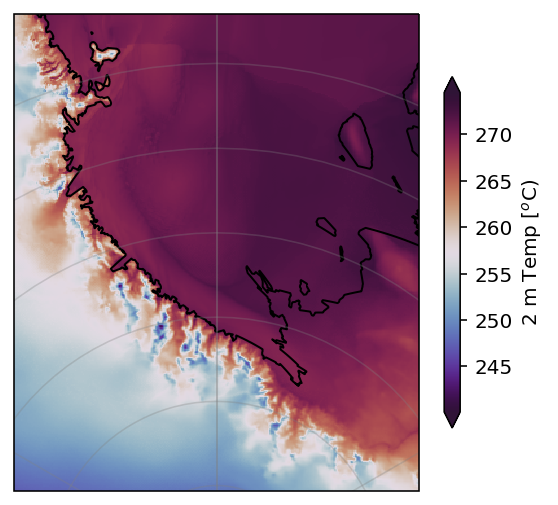

In [27]:
plot_time = 2
plot_var = 'T2'

import shapely.geometry as sgeom
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    
box = sgeom.box(minx=160, maxx=200, miny=-88, maxy=-76)
# box = sgeom.box(minx=-153, maxx=-159, miny=-84.85, maxy=-87.0)
# box = sgeom.box(minx=ds.XLONG.min(), maxx=ds.XLONG.max(), miny=ds.XLAT.min(), maxy=ds.XLAT.max())

x0, y0, x1, y1 = box.bounds
myproj = ccrs.SouthPolarStereo(central_longitude=180)
# myproj = ccrs.Orthographic()

fig = plt.figure(figsize=(4, 5), facecolor='white', dpi=144)
# ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea())
ax = plt.axes(projection=myproj)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())  
# ax.stock_img()
fig.canvas.draw()

pcm1 = ax.pcolormesh(AMPS_gcs.XLONG, AMPS_gcs.XLAT, AMPS_gcs[plot_var].isel(Time=plot_time)[:-1, :-1],
                     #vmin=210, vmax=275,
                     transform=ccrs.PlateCarree(), 
                     cmap=plt.get_cmap("twilight_shifted"))#, cmap=plt.get_cmap("gist_stern_r") # "BuPu", cmocean.cm.curl)

ax.coastlines(resolution='10m')
#         ax.add_feature(cartopy.feature.LAND)
#         ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines(draw_labels=False, alpha=0.3, color='grey')
ax.xformatter = LongitudeFormatter
ax.yformatter = LatitudeFormatter

cb1 = plt.colorbar(pcm1, ax=ax, label='2 m Temp [$^o$C)', \
                   orientation='vertical', extend='both', \
                  shrink=0.4, pad=0.05)

# ax.plot(lon2d.isel(south_north=si, west_east=sj), 
#         lat2d.isel(south_north=si, west_east=sj), 
#         'ko', markersize=3, transform=ccrs.PlateCarree())
# ax.plot(lon2d.isel(south_north=ai, west_east=aj), 
#         lat2d.isel(south_north=ai, west_east=aj), 
#         'ko', markersize=3, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.subplots_adjust(top=1.25)
# plt.suptitle(f"{ds.DX[0]/1000} km", y=0.98)
# plt.savefig(pfile, bbox_inches='tight')  # save the figure to file
plt.show()



### test salem...

In [ ]:
# import salem

# salem.open_mf_wrf_dataset(NCs_urls)

# TODO: add additional variables:

## Read in another diagnostic var

In [ ]:
da = wrf.getvar(wrflist, 
                "rh2", 
                timeidx=wrf.ALL_TIMES, 
                method='cat') #, method="join", squeeze=False)

In [ ]:
da = da.chunk(chunks={'Time':-1})
da

In [ ]:
ds = da.to_dataset()
ds

### append zarr
- OR append each DataSet onto existing zarr (http://xarray.pydata.org/en/stable/io.html#appending-to-existing-zarr-stores)

`>> ds2.to_zarr("path/to/directory.zarr", append_dim="t")`

In [ ]:
# del ds.T2.attrs['projection']
ds.rh2.attrs['projection'] = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'

# ds.to_zarr('data/test_local.zarr', mode='a') #, append_dim="Time")


### merge dataset

- `merge` DataArrays into single DataSet along Time timension (http://xarray.pydata.org/en/stable/combining.html#merge)

`>> xr.merge([ds, ds.rename({"foo": "bar"})])`

# Addendum

## test dissabling xarray
memory still >60 Gb!

In [ ]:
# Uncomment to disable xarray
wrf.disable_xarray()

# for i in range(150):
#     f = Dataset('wrfout_d01_2005-07-17_12_00_00.nc')
#     p = wrf.getvar(f, 'pressure')
#     f.close()
    
    
da = wrf.getvar(wrflist, 
                'slp', 
                timeidx=wrf.ALL_TIMES, 
                method='cat') #, method="join", squeeze=False)    

## "Loop and fill" method for RAM issues

In [60]:
from __future__ import print_function, division

# Result shape (hard coded for this example)
# result_shape = (289, 39, 300, 300)
# result_shape = tuple(ds.dims[d] for d in ['Time', 'bottom_top', 'south_north', 'west_east'])
result_shape = tuple(ds.dims[d] for d in ['Time', 'south_north', 'west_east'])

# Only need 4-byte floats
z_final = np.empty(result_shape, np.float32)

# Modify this number if using more than 1 time per file
times_per_file = 1

for timeidx in range(result_shape[0]):
    # Compute the file index and the time index inside the file
    fileidx = timeidx // times_per_file
    file_timeidx = timeidx % times_per_file

    f = Dataset(NCs_urls[fileidx])
    z = wrf.getvar(f, "slp", file_timeidx)

    z_final[timeidx,:] = z[:]
    f.close()

### make it a DataArray

In [109]:
# ds_pp = xr.full_like(ds, np.nan).chunk({"Time": -1}).rename_vars({'T2':'slp'})
# ds_pp = ds.update({"slp": z_final})

ds_pp = ds.rename_vars({'T2':'slp'})
ds_pp = ds_pp.copy(data={"slp": z_final})


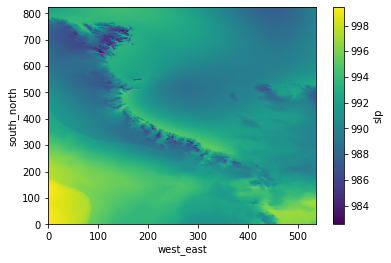

In [110]:
ds_pp.slp.mean(dim='Time').plot()

In [133]:
# # from scratch
da_pp = xr.DataArray(z_final, ds.coords, ds.dims, ds.attrs).chunk({"Time": -1})
# da_pp = da_pp.time.assign_attrs(units=newtimeattr)

ds_pp = da_pp.to_dataset(name='slp')
ds_pp.slp

<xarray.DataArray 'slp' (Time: 56, south_north: 825, west_east: 537)>
dask.array<xarray-<this-array>, shape=(56, 825, 537), dtype=float32, chunksize=(56, 825, 537), chunktype=numpy.ndarray>
Coordinates:
    XLONG     (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    XLAT      (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    XTIME     (Time) float64 dask.array<chunksize=(56,), meta=np.ndarray>
  * Time      (Time) datetime64[ns] 2016-12-25T18:00:00 ... 2016-12-27T12:00:00
    datetime  (Time) datetime64[ns] dask.array<chunksize=(56,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east

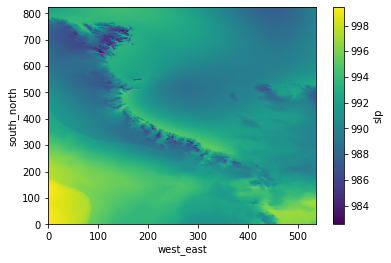

In [136]:
ds_pp['slp'].mean(dim='Time').plot()

## Plot Scott and Amundsen plots

In [148]:
scott = (-154.2, -85.3)
amundsen = (-159.6, -85.4)

NameError: name 'interpline' is not defined

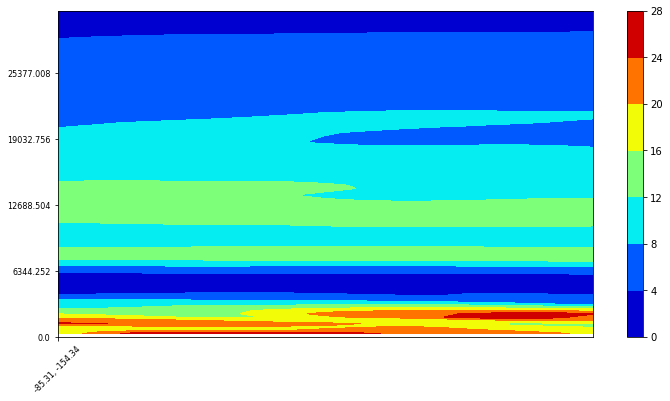

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset

from wrf import to_np, getvar, CoordPair, vertcross

# Open the NetCDF file
ncfile = Dataset(NCs_urls[0])

# Extract the model height and wind speed
ter = getvar(ncfile, "ter", timeidx=-1)
z = getvar(ncfile, "z")
wspd =  getvar(ncfile, "uvmet_wspd_wdir", units="kt")[0,:]

# Create the start point and end point for the cross section
start_point = CoordPair(lat=scott[1], lon=scott[0])
end_point = CoordPair(lat=amundsen[1], lon=amundsen[0])

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section.
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

# Create the figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

# Make the contour plot
wspd_contours = ax.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))

# Add the color bar
plt.colorbar(wspd_contours, ax=ax)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(wspd_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)

# Set the y-ticks to be height.
vert_vals = to_np(wspd_cross.coords["vertical"])
hori_vals = np.arange(0, wspd_cross.shape[-1], 1)
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::20])
ax.set_yticklabels(vert_vals[::20], fontsize=8)

# Fill in the mountain area
ter_line = interpline(ter, wrfin=ncfile, start_point=start_point,
                      end_point=end_point)
ht_fill = ax.fill_between(xs, 0, to_np(ter_line),
                                facecolor="saddlebrown")

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)

plt.title("Vertical Cross Section of Wind Speed (kt)")

plt.show()

In [ ]:
ter_line.plot()

In [ ]:
print(f'start: {start_point}\nend: {end_point}')

In [ ]:
import numpy as np
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)

wrf_file = Dataset(NCs_urls[0])

# Define the cross section start and end points
start_point = CoordPair(lat=scott[1], lon=-scott[0])
end_point = CoordPair(lat=amundsen[1], lon=-amundsen[0])
cross_start = start_point
cross_end = end_point

# Get the WRF variables
ht = getvar(wrf_file, "z", timeidx=-1)
ter = getvar(wrf_file, "ter", timeidx=-1)
dbz = getvar(wrf_file, "dbz", timeidx=-1)
max_dbz = getvar(wrf_file, "mdbz", timeidx=-1)
Z = 10**(dbz/10.) # Use linear Z for interpolation

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
z_cross = vertcross(Z, ht, wrfin=wrf_file,
                    start_point=cross_start,
                    end_point=cross_end,
                    latlon=True, meta=True)

# Convert back to dBz after interpolation
dbz_cross = 10.0 * np.log10(z_cross)

# Add back the attributes that xarray dropped from the operations above
dbz_cross.attrs.update(z_cross.attrs)
dbz_cross.attrs["description"] = "radar reflectivity cross section"
dbz_cross.attrs["units"] = "dBZ"

# To remove the slight gap between the dbz contours and terrain due to the
# contouring of gridded data, a new vertical grid spacing, and model grid
# staggering, fill in the lower grid cells with the first non-missing value
# for each column.

# Make a copy of the z cross data. Let's use regular numpy arrays for this.
dbz_cross_filled = np.ma.copy(to_np(dbz_cross))

# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(dbz_cross_filled.shape[-1]):
    column_vals = dbz_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    dbz_cross_filled[0:first_idx, i] = dbz_cross_filled[first_idx, i]

# Get the terrain heights along the cross section line
ter_line = interpline(ter, wrfin=wrf_file, start_point=cross_start,
                      end_point=cross_end)

# Get the lat/lon points
lats, lons = latlon_coords(dbz)

# Get the cartopy projection object
cart_proj = get_cartopy(dbz)

# Create the figure
fig = pyplot.figure(figsize=(8,6))
ax_cross = pyplot.axes()

dbz_levels = np.arange(5., 75., 5.)

# Create the color table found on NWS pages.
dbz_rgb = np.array([[4,233,231],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")

# Make the cross section plot for dbz
dbz_levels = np.arange(5.,75.,5.)
xs = np.arange(0, dbz_cross.shape[-1], 1)
ys = to_np(dbz_cross.coords["vertical"])
dbz_contours = ax_cross.contourf(xs,
                                 ys,
                                 to_np(dbz_cross_filled),
                                 levels=dbz_levels,
                                 cmap=dbz_map,
                                 norm=dbz_norm,
                                 extend="max")
# Add the color bar
cb_dbz = fig.colorbar(dbz_contours, ax=ax_cross)
cb_dbz.ax.tick_params(labelsize=8)

# Fill in the mountain area
ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),
                                facecolor="saddlebrown")

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)

# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("Latitude, Longitude", fontsize=12)
ax_cross.set_ylabel("Height (m)", fontsize=12)

# Add a title
ax_cross.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 14})

pyplot.show()


# Cluster shutdown

In [ ]:
cluster.shutdown()
